In [6]:
trials = read.csv("clinical_trial.csv", fileEncoding="latin1", stringsAsFactors=FALSE)

In [8]:
max(nchar(trials$abstract))

[1] 3708

In [9]:
sum(nchar(trials$abstract) == 0)

[1] 112

In [13]:
trials$title[which.min(nchar(trials$title))]

[1] "A decade of letrozole: FACE."

In [14]:
library(tm)
library(SnowballC)

Loading required package: NLP


In [20]:
corpusTitle = VCorpus(VectorSource(trials$title)) 
corpusTitle = tm_map(corpusTitle, content_transformer(tolower))
corpusTitle = tm_map(corpusTitle, removePunctuation)
corpusTitle = tm_map(corpusTitle, removeWords, c(stopwords("english")))
corpusTitle = tm_map(corpusTitle, stemDocument)

corpusAbstract = VCorpus(VectorSource(trials$abstract))
corpusAbstract = tm_map(corpusAbstract, content_transformer(tolower))
corpusAbstract = tm_map(corpusAbstract, removePunctuation)
corpusAbstract = tm_map(corpusAbstract, removeWords, c(stopwords("english")))
corpusAbstract = tm_map(corpusAbstract, stemDocument)

In [21]:
dtmTitle = DocumentTermMatrix(corpusTitle)
dtmTitle = removeSparseTerms(dtmTitle, 0.95)
dtmTitle = as.data.frame(as.matrix(dtmTitle))

dtmAbstract = DocumentTermMatrix(corpusAbstract)
dtmAbstract = removeSparseTerms(dtmAbstract, 0.95)
dtmAbstract = as.data.frame(as.matrix(dtmAbstract))

In [23]:
ncol(dtmTitle)
ncol(dtmAbstract)

[1] 31

[1] 335

In [24]:
which.max(colSums(dtmAbstract))

patient 
    212

In [25]:
colnames(dtmTitle) = paste0("T", colnames(dtmTitle))
colnames(dtmAbstract) = paste0("A", colnames(dtmAbstract))

In [26]:
dtm = cbind(dtmTitle, dtmAbstract)

In [27]:
dtm$trial = trials$trial

In [28]:
ncol(dtm)

[1] 367

In [30]:
library(caTools)
set.seed(144)
split = sample.split(dtm$trial, SplitRatio = 0.7)
train = subset(dtm, split==TRUE)
test = subset(dtm, split==FALSE)

In [31]:
table(train$trial)


  0   1 
730 572 

In [33]:
730 / nrow(train)

[1] 0.5606759

In [34]:
library(rpart)
library(rpart.plot)

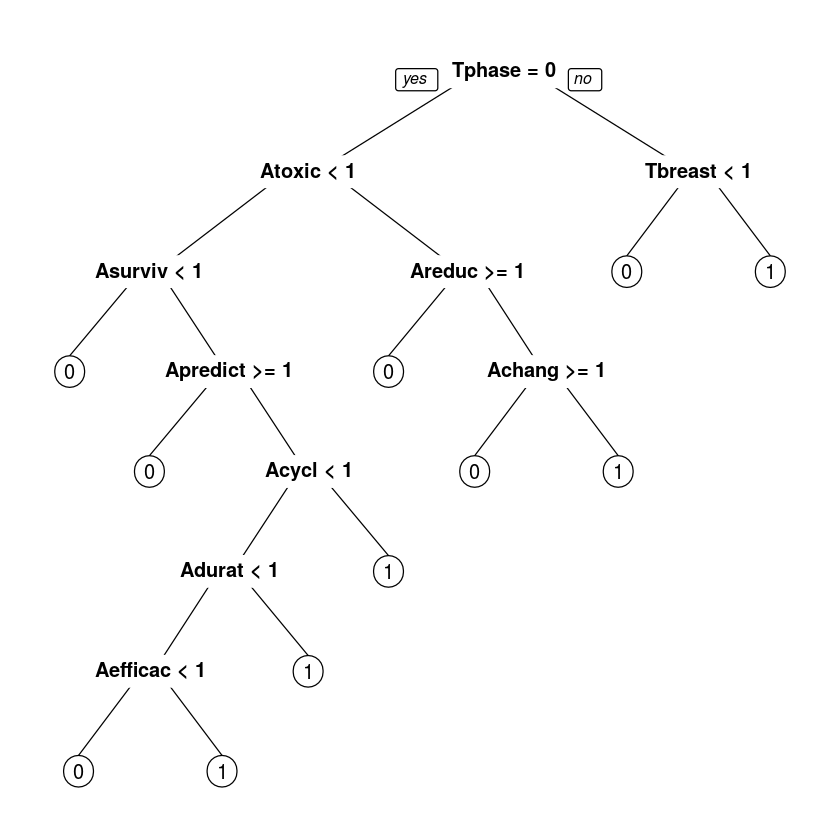

In [37]:
trialCART = rpart(trial ~ ., data = train, method = "class")
prp(trialCART)

In [38]:
max(predict(trialCART)[,2])

[1] 0.8718861

In [39]:
table(train$trial, predict(trialCART)[,2]>0.5)

   
    FALSE TRUE
  0   631   99
  1   131  441

In [43]:
(631 + 441) / nrow(train)
441 / (441 + 131)
631 / (631 + 99)

[1] 0.8233487

[1] 0.770979

[1] 0.8643836

In [45]:
testPredict = predict(trialCART, newdata = test)

In [46]:
table(testPredict[,2] > .5, test$trial)

       
          0   1
  FALSE 261  83
  TRUE   52 162

In [47]:
(261 + 162) / nrow(test)

[1] 0.7580645

In [55]:
library(ROCR)
as.numeric(performance(prediction(testPredict[,2], test$trial), "auc")@y.values)

[1] 0.8371063